[View in Colaboratory](https://colab.research.google.com/github/ZackAkil/rotting-zombie-model/blob/master/Feedback_analyse_from_DataStore.ipynb)

# Feedback analyse
We will look at how you can extract data out of DataStore and check if the model is rotting.

In [0]:
# install DataStore python library
!pip install -qq google-cloud-datastore

In [0]:
from google.cloud import datastore

In [0]:
# autheticate to our Google Cloud Platform account
from google.colab import auth
auth.authenticate_user()

## Connect to DataStore

In [0]:
PROJECT_ID = 'zacks-first'

# connect to DataStore
client = datastore.Client(PROJECT_ID)

## Query DataStore

In [0]:
# query for all prediction-feedback items
query = client.query(kind='prediction-feedback')

# order by the time field
query.order = ['time']

# fetch the items (returns an iterator so we will empty it into a list)
data = list(query.fetch())

In [33]:
# lets look at a single item
data[0]

<Entity('prediction-feedback', 5679790782676992) {'prediction': 1, 'input data': [-0.8300105114555543, 0.3990742221560673, 1.9084475908892906, 0.3804372006233603], 'was correct': True, 'model': 'v1', 'time': datetime.datetime(2018, 10, 22, 14, 21, 2, 199917, tzinfo=<UTC>)}>

In [34]:
# look at single items fields
print(data[0]['was correct'])
print(data[0]['model'])
print(data[0]['time'])
print(data[0]['input data'])

True
v1
2018-10-22 14:21:02.199917+00:00
[-0.8300105114555543, 0.3990742221560673, 1.9084475908892906, 0.3804372006233603]


## What percentage of feedback were  'was correct' was True

In [35]:
number_of_items = len(data)
number_of_was_correct = len([d for d in data if d['was correct']])


print('{0} total number of items, {1} total number of items were "was correct" is set to True'.format(number_of_items, 
                                                                                                      number_of_was_correct))

250 total number of items, 210 total number of items were "was correct" is set to True


In [36]:
# what ratio are correct i.e the accuracy of the model
number_of_was_correct/number_of_items

0.84

## Let's check to see if the accuracy is consistent over time

In [0]:
import matplotlib.pyplot as plt

def plot_performance(data, window = 50):
  '''
  Will calculate the accuracy using a sliding window on the data.
  '''
  
  perf = []

  for i in range(len(data) - window):
    data_slice = data[i:i+window]
    accuracy = len([d for d in data_slice if d['was correct']]) / len(data_slice)
    perf.append(accuracy)

  plt.ylabel('Accuracy')
  plt.plot(perf)

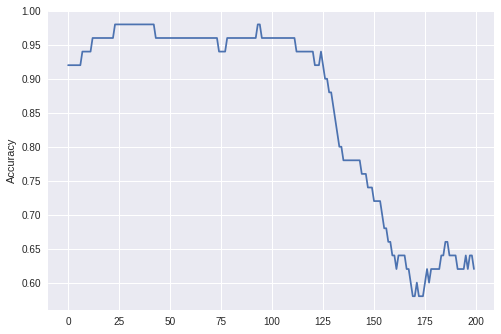

In [48]:
plot_performance(data)

### So our model appears to have recently gotten a lot worse in performance  

## Let's look at the corresponding input data that was submitted  

In [0]:
import numpy as np

def plot_input_data(data, start_index, window_size = 50):
  
  data_window = data[start_index : start_index + window_size]
  
  points = [d['input data'] for d in data_window]
  correct = [int(d['was correct']) for d in data_window]

  np_points = np.array(points)

  plt.scatter(np_points[:,0], np_points[:,1], c=correct, cmap='bwr_r')
  plt.show()

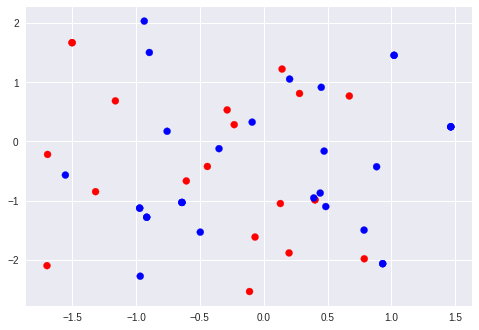

In [84]:
#@title Inspect input data { run: "auto" }
start = 168 #@param {type:"slider", min:0, max:200, step:1}

plot_input_data(data, start)

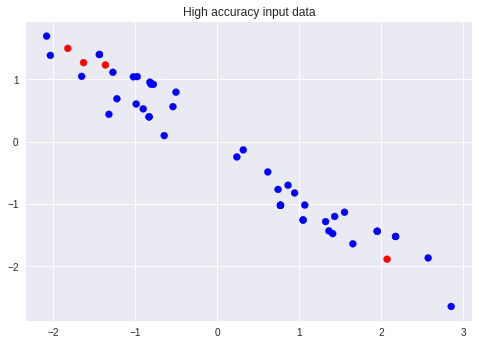

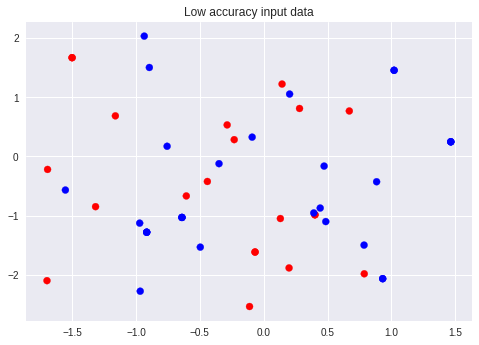

In [85]:
plt.title('High accuracy input data')
plot_input_data(data, 0)

plt.title('Low accuracy input data')
plot_input_data(data, 170)

We can see that the input data was very different in the more recent feedback (were it got a low accuracy).

We can guesse that the zombie population has mutated and we'll need to retrain our model on the new data collected (plus maybe go out and collect some more data of our own to confirm this hypothosis).

## Let's collect and save the data from DataStore into a new data set

In [0]:
# performance dropped after the 125th item
new_data = data[125:]

In [96]:
# extract the input data
new_x = np.array([d['input data'] for d in new_data])
new_x.shape

(125, 4)

In [102]:
# extract the target y
# BUT remember to flip it if the user said it was and incorrect prediction

new_y = []

for item in new_data:
  
  if item['was correct']:
    # if the prediction was correct then just save the prediction as is    
    new_y.append(item['prediction'])
    
  else:
    # if it was incorrect then flip the prediction
    if item['prediction'] == 0:
      new_y.append(1)
    else:
      new_y.append(0)
      
new_y = np.array(new_y)

new_y.shape

(125,)

In [105]:
from sklearn.externals import joblib

# save data
joblib.dump({"x":new_x, "y":new_y}, "zombie_data_2.joblib" )

['zombie_data_2.joblib']